# Import Libraries

In [46]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib notebook
from argparse import ArgumentParser
import yaml
import os
import torch
# from torch import vmap
from functorch import vmap, grad

from models import FNN2d, FNN2d_AD
from train_utils import Adam
# from train_utils.datasets import BurgersLoader'
# from train_utils.train_2d import train_2d_burger
# from train_utils.eval_2d import eval_burgers

from solver.BurgersEq import BurgersEq1D
import traceback

import scipy.io
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

import imageio



from tqdm import tqdm
from train_utils.utils import get_grid, save_checkpoint, torch2dgrid, load_checkpoint, load_config, update_config
from train_utils.losses import LpLoss
from train_utils.datasets import DataLoader1D
# from utils import torch2dgrid
from solver.my_random_fields import GRF_Mattern

from importlib import reload

try:
    import wandb
except ImportError:
    wandb = None


# Define Loss Functions

## Spectral Derivatives

In [47]:
def FDM_Burgers(u, D=1, nu=0.01):
    batchsize = u.size(0)
    nt = u.size(1)
    nx = u.size(2)

    u = u.reshape(batchsize, nt, nx)
    u2 = u**2
    dt = D / (nt-1)
    dx = D / (nx)

    u_h = torch.fft.fft(u, dim=2)
    u2_h = torch.fft.fft(u2, dim=2)
    # Wavenumbers in y-direction
    k_max = nx//2
    k_x = torch.cat((torch.arange(start=0, end=k_max, step=1, device=u.device),
                     torch.arange(start=-k_max, end=0, step=1, device=u.device)), 0).reshape(1,1,nx)
    ux_h = 2j *np.pi*k_x*u_h
    u2x_h = 2j *np.pi*k_x*u2_h
    uxx_h = 2j *np.pi*k_x*ux_h
    ux = torch.fft.irfft(ux_h[:, :, :k_max+1], dim=2, n=nx)
    u2x = torch.fft.irfft(u2x_h[:, :, :k_max+1], dim=2, n=nx)
    uxx = torch.fft.irfft(uxx_h[:, :, :k_max+1], dim=2, n=nx)
    ut = (u[:, 2:, :] - u[:, :-2, :]) / (2 * dt)
    Du = ut + (0.5*u2x - nu*uxx)[:,1:-1,:]
#     Du = ut + (u*ux - nu*uxx)[:,1:-1,:]
    return Du

def PINO_loss_Burgers(u, u0, nu=0.01):
    batchsize = u.size(0)
    nt = u.size(1)
    nx = u.size(2)

    u = u.reshape(batchsize, nt, nx)
    # lploss = LpLoss(size_average=True)

    index_t = torch.zeros(nx,).long()
    index_x = torch.tensor(range(nx)).long()
    boundary_u = u[:, index_t, index_x]
    loss_u = F.mse_loss(boundary_u, u0)

    Du = FDM_Burgers(u, nu=nu)[:, :, :]
    f = torch.zeros(Du.shape, device=u.device)
    loss_f = F.mse_loss(Du, f)

    # loss_bc0 = F.mse_loss(u[:, :, 0], u[:, :, -1])
    # loss_bc1 = F.mse_loss((u[:, :, 1] - u[:, :, -1]) /
    #                       (2/(nx)), (u[:, :, 0] - u[:, :, -2])/(2/(nx)))
    return loss_u, loss_f

# Define Training Function

In [48]:
def train_Burgers(model,
                  train_loader,
                  optimizer, 
                  scheduler,
                  config,
                  rank=0,
                  log=False,
                  project='PINO-2d-default',
                  group='default',
                  tags=['default'],
                  use_tqdm=True):
    if rank == 0 and wandb and log:
        run = wandb.init(project=project,
                         entity='shawngr2',
                         group=group,
                         config=config,
                         tags=tags, reinit=True,
                         settings=wandb.Settings(start_method="fork"))

    data_weight = config['train']['xy_loss']
    f_weight = config['train']['f_loss']
    ic_weight = config['train']['ic_loss']
    nu = config['data']['nu']
    ckpt_freq = config['train']['ckpt_freq']

    model.train()
    myloss = LpLoss(size_average=True)
    
    pbar = range(config['train']['epochs'])
    if use_tqdm:
        pbar = tqdm(pbar, dynamic_ncols=True, smoothing=0.1)

    for e in pbar:
        model.train()
        train_pino = 0.0
        data_l2 = 0.0
        train_loss = 0.0

        for x, y in train_loader:
            x, y = x.to(rank), y.to(rank)
            out = model(x).reshape(y.shape)
            data_loss = myloss(out, y)
            
            loss_u, loss_f = PINO_loss_Burgers(out, x[:, 0, :, 0], nu=nu)
            total_loss = loss_u * ic_weight + loss_f * f_weight + data_loss * data_weight

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            data_l2 += data_loss.item()
            train_pino += loss_f.item()
            train_loss += total_loss.item()
        scheduler.step()
        data_l2 /= len(train_loader)
        train_pino /= len(train_loader)
        train_loss /= len(train_loader)
        if use_tqdm:
            pbar.set_description(
                (
                    f'Epoch {e}, train loss: {train_loss:.5f} '
                    f'train f error: {train_pino:.5f}; '
                    f'data l2 error: {data_l2:.5f}'
                )
            )
        if wandb and log:
            wandb.log(
                {
                    'Train f error': train_pino,
                    'Train L2 error': data_l2,
                    'Train loss': train_loss,
                }
            )

        if e % ckpt_freq == 0:
            save_checkpoint(config['train']['save_dir'],
                            config['train']['save_name'].replace('.pt', f'_{e}.pt'),
                            model, optimizer)
    save_checkpoint(config['train']['save_dir'],
                    config['train']['save_name'],
                    model, optimizer)
    print('Done!')

In [49]:
def train_Burgers_padding(model,
                          train_loader,
                          optimizer, 
                          scheduler,
                          config,
                          padding=0,
                          rank=0,
                          log=False,
                          project='PINO-2d-default',
                          group='default',
                          tags=['default'],
                          use_tqdm=True):
    
    if rank == 0 and wandb and log:
        run = wandb.init(project=project,
                         entity='shawngr2',
                         group=group,
                         config=config,
                         tags=tags, reinit=True,
                         settings=wandb.Settings(start_method="fork"))

    data_weight = config['train']['xy_loss']
    f_weight = config['train']['f_loss']
    ic_weight = config['train']['ic_loss']
    nu = config['data']['nu']
    ckpt_freq = config['train']['ckpt_freq']
    model.train()
    myloss = LpLoss(size_average=True)
    
    pbar = range(config['train']['epochs'])
    if use_tqdm:
        pbar = tqdm(pbar, dynamic_ncols=True, smoothing=0.1)

    for e in pbar:
        model.train()
        train_pino = 0.0
        data_l2 = 0.0
        train_loss = 0.0

        for x, y in train_loader:
            x, y = x.to(rank), y.to(rank)
#             print(y.shape)
            x_in = F.pad(x, (0, 0, 0, 0, 0, padding), "constant", 0)
#             display(x.shape, x_in.shape)
            batch_size, T, S = old_shape = y.shape
            new_shape = (batch_size, T + padding, S)
            out = model(x_in).reshape(batch_size, T + padding, S)
            out = out[..., :-padding, :]
            
#             out = model(x).reshape(y.shape)
            u0 = x[:, 0, :, 0]
    
            data_loss = myloss(out.view(batch_size, T, S), y.view(batch_size, T, S))
            
            loss_u, loss_f = PINO_loss_Burgers(out.view(batch_size, T, S), u0, nu=nu)
            total_loss = loss_u * ic_weight + loss_f * f_weight + data_loss * data_weight

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            data_l2 += data_loss.item()
            train_pino += loss_f.item()
            train_loss += total_loss.item()
        scheduler.step()
        data_l2 /= len(train_loader)
        train_pino /= len(train_loader)
        train_loss /= len(train_loader)
        if use_tqdm:
            pbar.set_description(
                (
                    f'Epoch {e}, train loss: {train_loss:.5f} '
                    f'train f error: {train_pino:.5f}; '
                    f'data l2 error: {data_l2:.5f}'
                )
            )
        if wandb and log:
            wandb.log(
                {
                    'Train f error': train_pino,
                    'Train L2 error': data_l2,
                    'Train loss': train_loss,
                }
            )

        if e % ckpt_freq == 0:
            save_checkpoint(config['train']['save_dir'],
                            config['train']['save_name'].replace('.pt', f'_{e}.pt'),
                            model, optimizer)
    save_checkpoint(config['train']['save_dir'],
                    config['train']['save_name'],
                    model, optimizer)
    print('Done!')

# Evaluation Function

In [51]:
def eval_Burgers(model,
                 dataloader,
                 config,
                 device,
                 use_tqdm=True):
    model.eval()
    myloss = LpLoss(size_average=True)
    nu = config['data']['nu']
    if use_tqdm:
        pbar = tqdm(dataloader, dynamic_ncols=True, smoothing=0.05)
    else:
        pbar = dataloader

    test_err = []
    f_err = []
    with torch.no_grad():
        for x, y in pbar:
            x, y = x.to(device), y.to(device)
            out = model(x).reshape(y.shape)
            data_loss = myloss(out, y)

            loss_u, f_loss = PINO_loss_Burgers(out, x[:, 0, :, 0], nu=nu)
            test_err.append(data_loss.item())
            f_err.append(f_loss.item())

    mean_f_err = np.mean(f_err)
    std_f_err = np.std(f_err, ddof=1) / np.sqrt(len(f_err))

    mean_err = np.mean(test_err)
    std_err = np.std(test_err, ddof=1) / np.sqrt(len(test_err))

    print(f'==Averaged relative L2 error mean: {mean_err}, std error: {std_err}==\n'
          f'==Averaged equation error mean: {mean_f_err}, std error: {std_f_err}==')


def eval_Burgers_padding(model,
                         dataloader,
                         config,
                         padding=0,
                         device=None,
                         use_tqdm=True):
    model.eval()
    myloss = LpLoss(size_average=True)
    nu = config['data']['nu']
    if use_tqdm:
        pbar = tqdm(dataloader, dynamic_ncols=True, smoothing=0.05)
    else:
        pbar = dataloader

    test_err = []
    f_err = []
    with torch.no_grad():
        for x, y in pbar:
            x, y = x.to(device), y.to(device)
            x_in = F.pad(x, (0, 0, 0, 0, 0, padding), "constant", 0)
            batch_size, T, S = old_shape = y.shape
            new_shape = (batch_size, T + padding, S)
            out = model(x_in).reshape(batch_size, T + padding, S)
            out = out[..., :-padding, :]
#             out = model(x).reshape(y.shape)
            data_loss = myloss(out, y)

            loss_u, f_loss = PINO_loss_Burgers(out, x[:, 0, :, 0], nu=nu)
            test_err.append(data_loss.item())
            f_err.append(f_loss.item())

    mean_f_err = np.mean(f_err)
    std_f_err = np.std(f_err, ddof=1) / np.sqrt(len(f_err))

    mean_err = np.mean(test_err)
    std_err = np.std(test_err, ddof=1) / np.sqrt(len(test_err))

    print(f'==Averaged relative L2 error mean: {mean_err}, std error: {std_err}==\n'
          f'==Averaged equation error mean: {mean_f_err}, std error: {std_f_err}==')
            
            
        

# Load Config

In [52]:
config_file = 'configs/custom/burgers-0003.yaml'
config = load_config(config_file)
display(config)

{'data': {'name': 'Burgers-0003',
  'total_num': 100,
  'n_train': 90,
  'n_test': 10,
  'nx': 128,
  'nt': 100,
  'sub': 1,
  'sub_t': 1,
  'nu': 0.01},
 'model': {'layers': [16, 24, 24, 32, 32],
  'modes1': [15, 12, 9, 9],
  'modes2': [15, 12, 9, 9],
  'fc_dim': 128,
  'activation': 'gelu'},
 'train': {'batchsize': 20,
  'epochs': 500,
  'milestones': [100, 200, 300, 400, 500],
  'base_lr': 0.001,
  'scheduler_gamma': 0.5,
  'ic_loss': 5.0,
  'f_loss': 1.0,
  'xy_loss': 5.0,
  'save_dir': 'Burgers',
  'save_name': 'Burgers-0003.pt',
  'ckpt': 'checkpoints/Burgers/Burgers-0003.pt',
  'ckpt_freq': 100},
 'log': {'project': 'PINO-Burgers', 'group': 'Burgers-0003'},
 'test': {'batchsize': 1, 'ckpt': 'checkpoints/Burgers/Burgers-0003.pt'}}

# Parameters

In [53]:
Nsamples = config['data']['total_num']
N = config['data']['nx']
Nt0 = config['data']['nt']
nu = config['data']['nu']
sub_x = config['data']['sub']
sub_t = config['data']['sub_t']
Nx = N // sub_x
Nt = Nt0 // sub_t + 1
dim = 1
l = 0.1
L = 1.0
sigma = 0.5 #2.0
Nu = None # 2.0
dt = 1.0e-4
tend = 1.0
save_int = int(tend/dt/Nt)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [54]:
grf = GRF_Mattern(dim, N, length=L, nu=Nu, l=l, sigma=sigma, boundary="periodic", device=device)
U0 = grf.sample(Nsamples)

In [55]:
U0.shape

torch.Size([100, 128])

In [56]:
nu

0.01

In [57]:
burgers_eq = BurgersEq1D(Nx=Nx, nu=nu, dt=dt, device=device)
save_interval = int(1e-2/dt)
U = vmap(burgers_eq.burgers_driver, in_dims=(0, None))(U0, save_interval) 

In [58]:
U

tensor([[[ 0.3385,  0.3372,  0.3335,  ...,  0.3272,  0.3336,  0.3373],
         [ 0.3342,  0.3341,  0.3316,  ...,  0.3195,  0.3270,  0.3319],
         [ 0.3295,  0.3305,  0.3291,  ...,  0.3118,  0.3201,  0.3260],
         ...,
         [ 0.0989,  0.1034,  0.1077,  ...,  0.0850,  0.0897,  0.0944],
         [ 0.0982,  0.1026,  0.1069,  ...,  0.0843,  0.0890,  0.0937],
         [ 0.0975,  0.1018,  0.1061,  ...,  0.0837,  0.0884,  0.0930]],

        [[-0.1386, -0.1466, -0.1539,  ..., -0.1088, -0.1199, -0.1298],
         [-0.1387, -0.1469, -0.1543,  ..., -0.1082, -0.1195, -0.1296],
         [-0.1387, -0.1470, -0.1545,  ..., -0.1076, -0.1192, -0.1295],
         ...,
         [-0.0320, -0.0349, -0.0374,  ..., -0.0218, -0.0255, -0.0289],
         [-0.0317, -0.0345, -0.0371,  ..., -0.0215, -0.0252, -0.0286],
         [-0.0313, -0.0342, -0.0367,  ..., -0.0212, -0.0249, -0.0282]],

        [[-0.0402, -0.0492, -0.0569,  ..., -0.0087, -0.0198, -0.0303],
         [-0.0391, -0.0478, -0.0553,  ..., -0

In [59]:
a = U0.cpu().float()
u = U.cpu().float()
display(u.shape,a.shape)

torch.Size([100, 101, 128])

torch.Size([100, 128])

In [61]:
display(config)

{'data': {'name': 'Burgers-0003',
  'total_num': 100,
  'n_train': 90,
  'n_test': 10,
  'nx': 128,
  'nt': 100,
  'sub': 1,
  'sub_t': 1,
  'nu': 0.01},
 'model': {'layers': [16, 24, 24, 32, 32],
  'modes1': [15, 12, 9, 9],
  'modes2': [15, 12, 9, 9],
  'fc_dim': 128,
  'activation': 'gelu'},
 'train': {'batchsize': 20,
  'epochs': 500,
  'milestones': [100, 200, 300, 400, 500],
  'base_lr': 0.001,
  'scheduler_gamma': 0.5,
  'ic_loss': 5.0,
  'f_loss': 1.0,
  'xy_loss': 5.0,
  'save_dir': 'Burgers',
  'save_name': 'Burgers-0003.pt',
  'ckpt': 'checkpoints/Burgers/Burgers-0003.pt',
  'ckpt_freq': 100},
 'log': {'project': 'PINO-Burgers', 'group': 'Burgers-0003'},
 'test': {'batchsize': 1, 'ckpt': 'checkpoints/Burgers/Burgers-0003.pt'}}

In [62]:
dataset = DataLoader1D(a, u, config['data']['nx'], config['data']['nt'])
train_loader = dataset.make_loader(config['data']['n_train'], config['train']['batchsize'], start=0, train=True)
test_loader = dataset.make_loader(config['data']['n_test'], config['test']['batchsize'], start=config['data']['n_train'], train=False)

In [63]:
model = FNN2d(modes1=config['model']['modes1'],
              modes2=config['model']['modes2'],
              fc_dim=config['model']['fc_dim'],
              layers=config['model']['layers'],
              activation=config['model']['activation'],
             ).to(device)

In [64]:
# model = FNN2d_AD(modes1=config['model']['modes1'],
#                   modes2=config['model']['modes2'],
#                   fc_dim=config['model']['fc_dim'],
#                   layers=config['model']['layers'],
#                   activation=config['model']['activation']).to(device)

In [65]:
log = False

optimizer = Adam(model.parameters(), betas=(0.9, 0.999),lr=config['train']['base_lr'])
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                 milestones=config['train']['milestones'],
                                                 gamma=config['train']['scheduler_gamma'])

# Load from checkpoint

In [68]:
load_checkpoint(model, ckpt_path=config['train']['ckpt'], optimizer=None)

Weights loaded from checkpoints/Burgers/Burgers-0003.pt


# Train the Model

In [87]:

train_Burgers(model,
              train_loader,
              optimizer,
              scheduler,
              config,
              rank=0,
              log=log,
              project=config['log']['project'],
              group=config['log']['group'])

Epoch 0, train loss: 9.18629 train f error: 1.11002; data l2 error: 0.77219:   0%|          | 1/500 [00:01<10:46,  1.29s/it]

Checkpoint is saved at checkpoints/Burgers/Burgers-eqn_0.pt


Epoch 100, train loss: 0.17171 train f error: 0.09016; data l2 error: 0.05862:  20%|██        | 101/500 [01:40<06:33,  1.01it/s]

Checkpoint is saved at checkpoints/Burgers/Burgers-eqn_100.pt


Epoch 200, train loss: 0.07791 train f error: 0.04141; data l2 error: 0.03043:  40%|████      | 201/500 [03:17<04:50,  1.03it/s]

Checkpoint is saved at checkpoints/Burgers/Burgers-eqn_200.pt


Epoch 300, train loss: 0.04921 train f error: 0.02600; data l2 error: 0.01976:  60%|██████    | 301/500 [04:58<03:18,  1.00it/s]

Checkpoint is saved at checkpoints/Burgers/Burgers-eqn_300.pt


Epoch 400, train loss: 0.04353 train f error: 0.02287; data l2 error: 0.01774:  80%|████████  | 401/500 [06:38<01:37,  1.02it/s]

Checkpoint is saved at checkpoints/Burgers/Burgers-eqn_400.pt


Epoch 499, train loss: 0.03301 train f error: 0.01730; data l2 error: 0.01377: 100%|██████████| 500/500 [08:23<00:00,  1.01s/it]

Checkpoint is saved at checkpoints/Burgers/Burgers-eqn.pt
Done!


In [67]:

train_Burgers_padding(model,
              train_loader,
              optimizer,
              scheduler,
              config,
              padding=5,
              rank=0,
              log=log,
              project=config['log']['project'],
              group=config['log']['group'])

Epoch 1, train loss: 0.44000 train f error: 0.00300; data l2 error: 0.08714:   0%|          | 2/500 [00:00<01:11,  6.98it/s]

Checkpoint is saved at checkpoints/Burgers/Burgers-0003_0.pt


Epoch 101, train loss: 0.03299 train f error: 0.00028; data l2 error: 0.00654:  20%|██        | 102/500 [00:12<00:48,  8.13it/s]

Checkpoint is saved at checkpoints/Burgers/Burgers-0003_100.pt


Epoch 201, train loss: 0.02519 train f error: 0.00024; data l2 error: 0.00499:  40%|████      | 202/500 [00:24<00:36,  8.10it/s]

Checkpoint is saved at checkpoints/Burgers/Burgers-0003_200.pt


Epoch 263, train loss: 0.01779 train f error: 0.00024; data l2 error: 0.00351:  53%|█████▎    | 264/500 [00:31<00:28,  8.30it/s]


KeyboardInterrupt: 

# Evaluate on Test Data

In [33]:
eval_Burgers(model, test_loader, config, device)

100%|██████████| 10/10 [00:00<00:00, 204.76it/s]

==Averaged relative L2 error mean: 0.20606629103422164, std error: 0.013313933544367053==
==Averaged equation error mean: 0.13087167739868164, std error: 0.02210541471210258==


In [69]:
eval_Burgers_padding(model, test_loader, config=config, padding=5, device=device)

100%|██████████| 10/10 [00:00<00:00, 304.63it/s]

==Averaged relative L2 error mean: 0.003938224259763956, std error: 0.0004110154305698449==
==Averaged equation error mean: 0.00019065745909756514, std error: 4.214409621097977e-05==


In [70]:
Nx = config['data']['nx']
Nt = config['data']['nt'] + 1
N = config['data']['n_test']
model.eval()
test_x = np.zeros((N,Nt,Nx,3))
preds_y = np.zeros((N,Nt,Nx))
test_y = np.zeros((N,Nt,Nx))
with torch.no_grad():
    for i, data in enumerate(test_loader):
        data_x, data_y = data
        data_x, data_y = data_x.to(device), data_y.to(device)
        pred_y = model(data_x).reshape(data_y.shape)
        test_x[i] = data_x.cpu().numpy()
        test_y[i] = data_y.cpu().numpy()
        preds_y[i] = pred_y.cpu().numpy()
#     data_loss = myloss(out, y)


# Generate Test Predictions

## Unpadded

In [36]:
Nx = config['data']['nx']
Nt = config['data']['nt'] + 1
N = config['data']['n_test']
model.eval()
test_x = np.zeros((N,Nt,Nx,3))
preds_y = np.zeros((N,Nt,Nx))
test_y = np.zeros((N,Nt,Nx))
with torch.no_grad():
    for i, data in enumerate(test_loader):
        data_x, data_y = data
        data_x, data_y = data_x.to(device), data_y.to(device)
        pred_y = model(data_x).reshape(data_y.shape)
        test_x[i] = data_x.cpu().numpy()
        test_y[i] = data_y.cpu().numpy()
        preds_y[i] = pred_y.cpu().numpy()
#     data_loss = myloss(out, y)

## Padding

In [37]:
data_x.shape

torch.Size([1, 101, 128, 3])

In [38]:
use_train_data = False
padding = 5
batch_size = config['test']['batchsize']
Nx = config['data']['nx']
# Ny = config['data']['nx']
Nt = config['data']['nt'] + 1
Ntest = config['data']['n_test']
Ntrain = config['data']['n_train']
loader = test_loader
if use_train_data:
    Ntest = Ntrain
    loader = train_loader
# in_dim = config['model']['in_dim']
# out_dim = config['model']['out_dim']

model.eval()
# model.to('cpu')
test_x = np.zeros((Ntest,Nt,Nx,3))
preds_y = np.zeros((Ntest,Nt,Nx))
test_y = np.zeros((Ntest,Nt,Nx))


with torch.no_grad():
    for i, data in enumerate(loader):
#     for i, data in enumerate(train_loader):
        data_x, data_y = data
        data_x, data_y = data_x.to(device), data_y.to(device)
#         data_x_pad = F.pad()
#         display(data_x.shape)
        data_x_pad = F.pad(data_x, (0, 0, 0, 0, 0, padding), "constant", 0)
        pred_y_pad = model(data_x_pad).reshape(batch_size, Nt + padding, Nx)
#         out = out[..., :-padding, :]
#         pred_y_pad = model(data_x_pad).reshape(batch_size, Nx, Ny, Nt + padding, out_dim)
        pred_y = pred_y_pad[..., :-padding, :].reshape(data_y.shape)
#         pred_y = model(data_x).reshape(data_y.shape)
        test_x[i] = data_x.cpu().numpy()
        test_y[i] = data_y.cpu().numpy()
#         test_y0[i] = data_x[..., 0, -out_dim:].cpu().numpy() # same way as in training code
        preds_y[i] = pred_y.cpu().numpy()
#     data_loss = myloss(out, y)

In [39]:
len(preds_y)

10

In [40]:
key = 0
pred = preds_y[key]
true = test_y[key]


a = test_x[key]
Nt, Nx, _ = a.shape
u0 = a[0,:,0]
T = a[:,:,2]
X = a[:,:,1]
x = X[0]

In [41]:
fig = plt.figure(figsize=(24,5))
plt.subplot(1,4,1)

plt.plot(x, u0)
plt.xlabel('$x$')
plt.ylabel('$u$')
plt.title('Intial Condition $u(x)$')
plt.xlim([0,1])
plt.tight_layout()

plt.subplot(1,4,2)
# plt.pcolor(XX,TT, S_test, cmap='jet')
plt.pcolormesh(X, T, true, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title(f'Exact $s(x,t)$')
plt.tight_layout()
plt.axis('square')

plt.subplot(1,4,3)
# plt.pcolor(XX,TT, S_pred, cmap='jet')
plt.pcolormesh(X, T, pred, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title(f'Predict $s(x,t)$')
plt.axis('square')

plt.tight_layout()

plt.subplot(1,4,4)
# plt.pcolor(XX,TT, S_pred - S_test, cmap='jet')
plt.pcolormesh(X, T, pred - true, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Absolute error')
plt.tight_layout()
plt.axis('square')

# plt.show()

<IPython.core.display.Javascript object>

(0.0, 1.0, 0.0, 1.0)

# Save and Load Data

In [42]:
def save_data(data_path, test_x, test_y, preds_y):
    data_dir, data_filename = os.path.split(data_path)
    os.makedirs(data_dir, exist_ok=True)
    np.savez(data_path, test_x=test_x, test_y=test_y, preds_y=preds_y)

def load_data(data_path):
    data = np.load(data_path)
    test_x = data['test_x']
    test_y = data['test_y']
    preds_y = data['preds_y']
    return test_x, test_y, preds_y

In [15]:
data_dir = 'data/Burgers1D'
data_filename = 'data.npz'
data_path = os.path.join(data_dir, data_filename)
# os.makedirs(data_dir, exist_ok=True)


In [34]:
save_data(data_path, test_x, test_y, preds_y)

In [16]:
test_x, test_y, preds_y = load_data(data_path)

In [8]:
def plot_predictions(key, test_x, test_y, preds_y, print_index=False, save_path=None, font_size=None):
    if font_size is not None:
        plt.rcParams.update({'font.size': font_size})
    pred = preds_y[key]
    true = test_y[key]


    a = test_x[key]
    Nt, Nx, _ = a.shape
    u0 = a[0,:,0]
    T = a[:,:,2]
    X = a[:,:,1]
    x = X[0]

    # Plot
    fig = plt.figure(figsize=(23,5))
    plt.subplot(1,4,1)

    plt.plot(x, u0)
    plt.xlabel('$x$')
    plt.ylabel('$u$')
    plt.title('Intial Condition $u(x)$')
    plt.xlim([0,1])
    plt.tight_layout()

    plt.subplot(1,4,2)
    # plt.pcolor(XX,TT, S_test, cmap='jet')
    plt.pcolormesh(X, T, true, cmap='jet', shading='gouraud')
    plt.colorbar()
    plt.xlabel('$x$')
    plt.ylabel('$t$')
    plt.title(f'Exact $u(x,t)$')
    plt.tight_layout()
    plt.axis('square')

    plt.subplot(1,4,3)
    # plt.pcolor(XX,TT, S_pred, cmap='jet')
    plt.pcolormesh(X, T, pred, cmap='jet', shading='gouraud')
    plt.colorbar()
    plt.xlabel('$x$')
    plt.ylabel('$t$')
    plt.title(f'Predict $u(x,t)$')
    plt.axis('square')

    plt.tight_layout()

    plt.subplot(1,4,4)
    # plt.pcolor(XX,TT, S_pred - S_test, cmap='jet')
    plt.pcolormesh(X, T, pred - true, cmap='jet', shading='gouraud')
    plt.colorbar()
    plt.xlabel('$x$')
    plt.ylabel('$t$')
    plt.title('Absolute Error')
    plt.tight_layout()
    plt.axis('square')

    if save_path is not None:
        plt.savefig(f'{save_path}.png', bbox_inches='tight')
    plt.show()

    


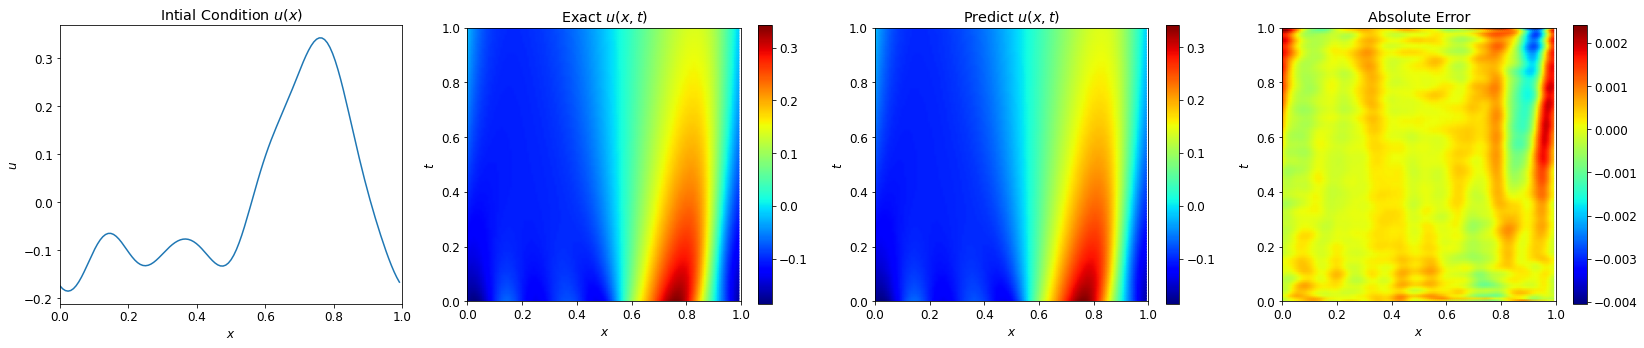

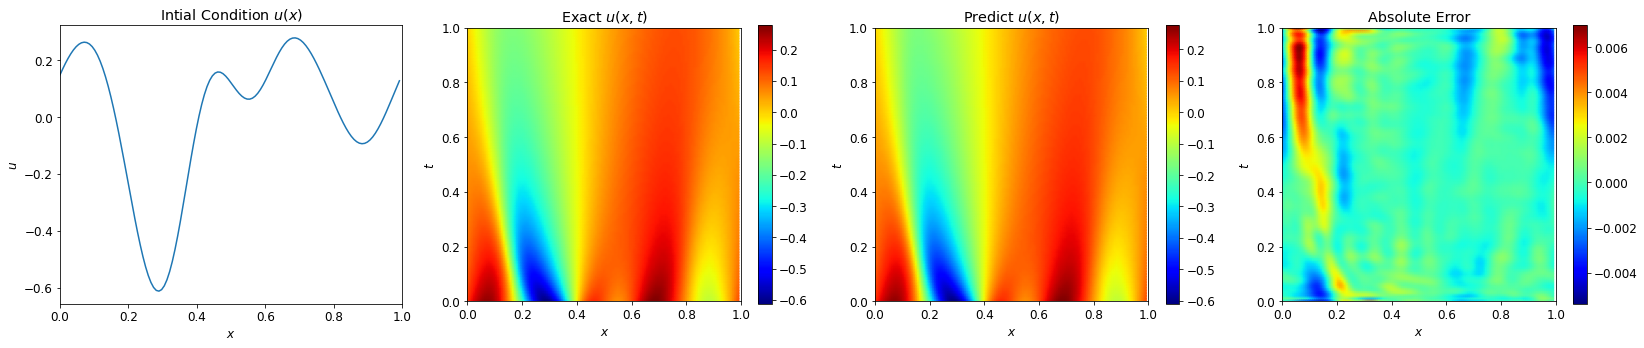

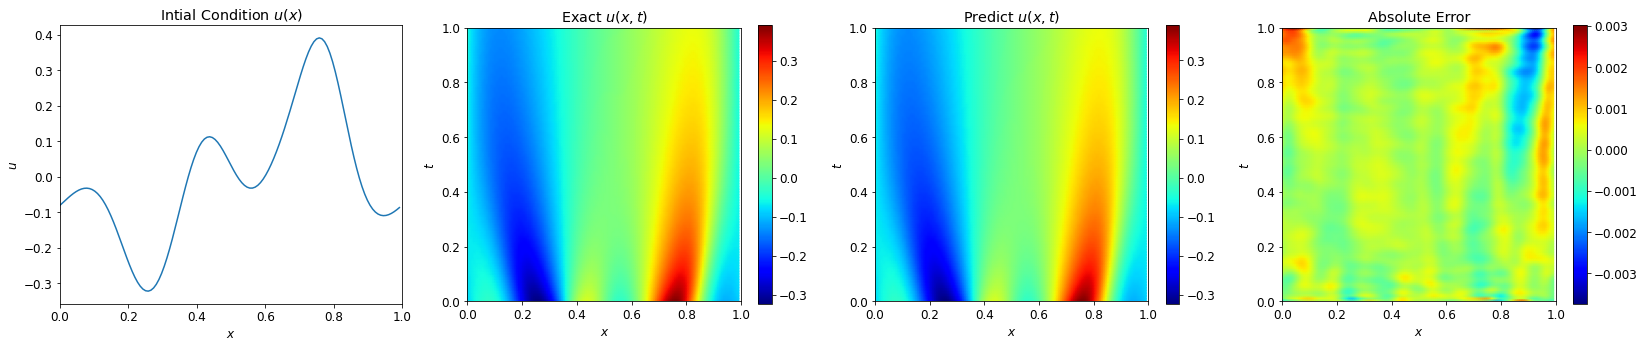

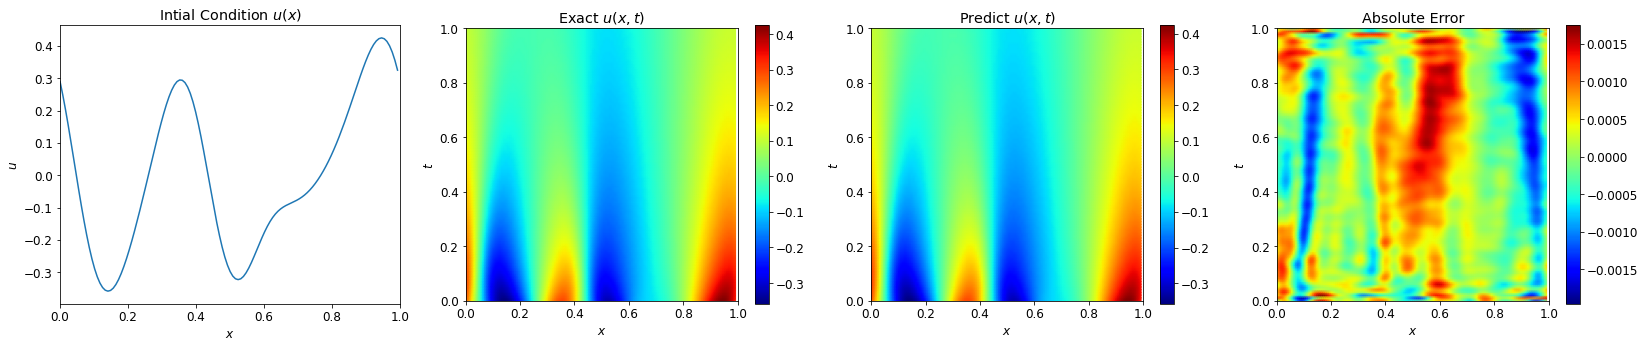

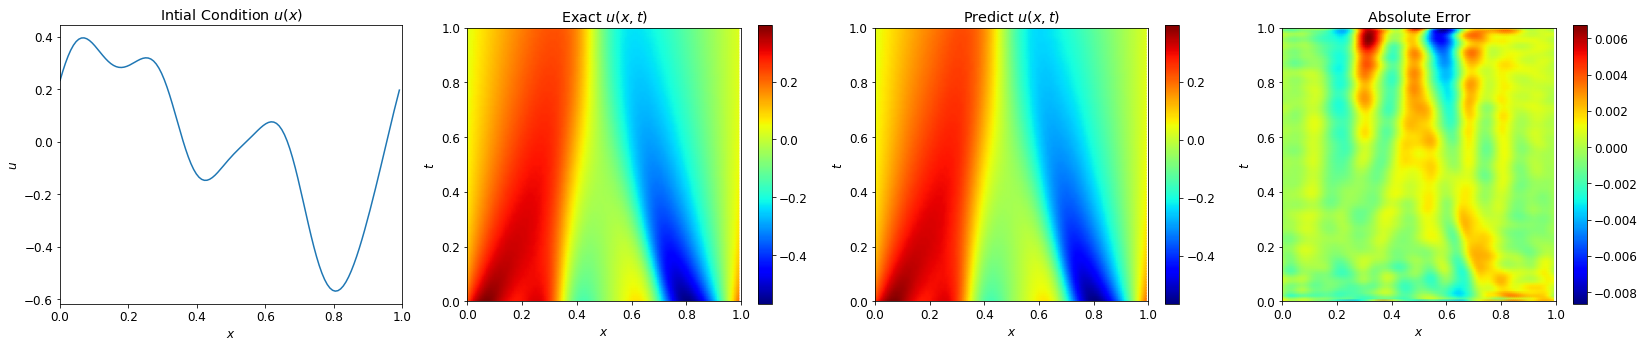

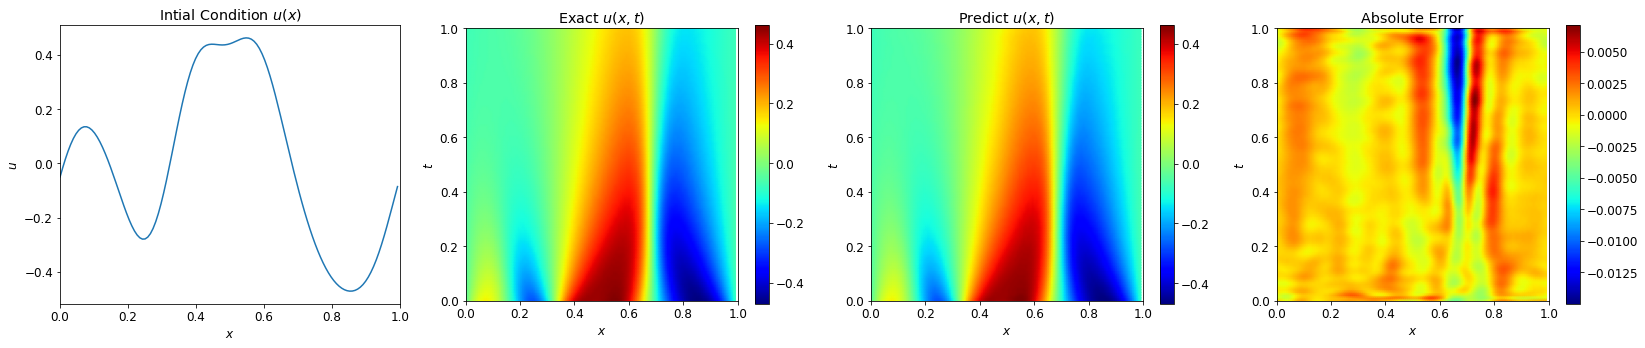

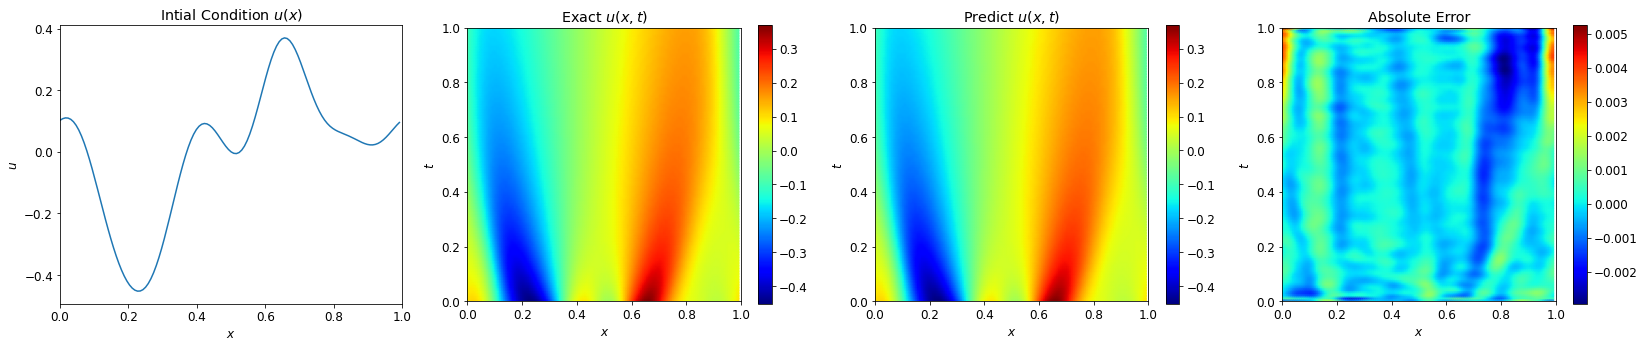

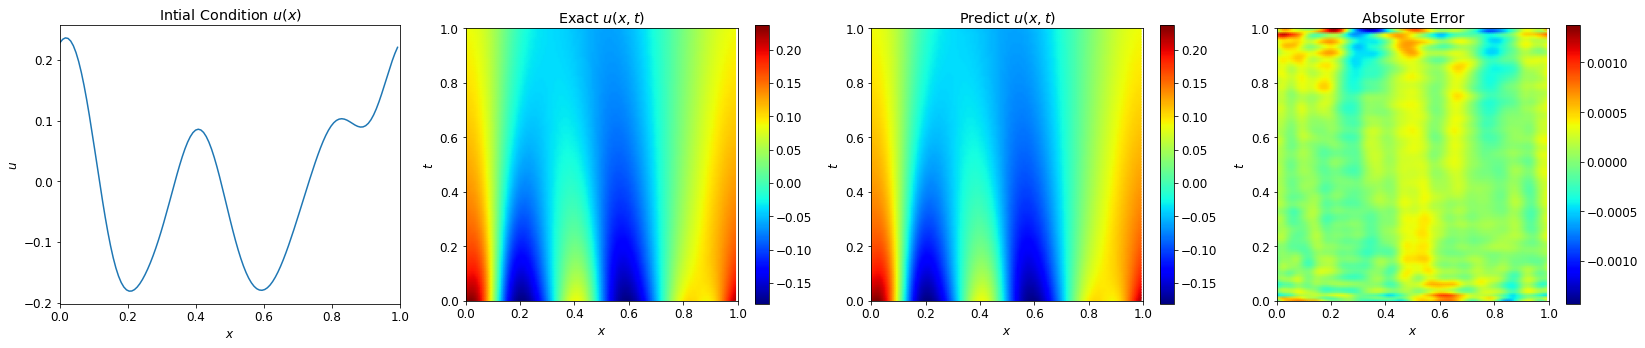

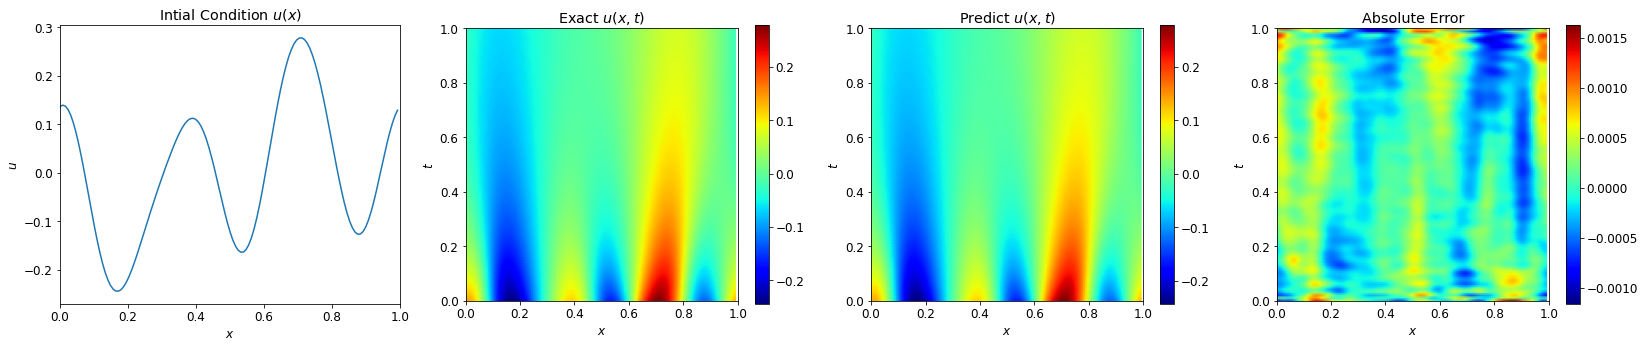

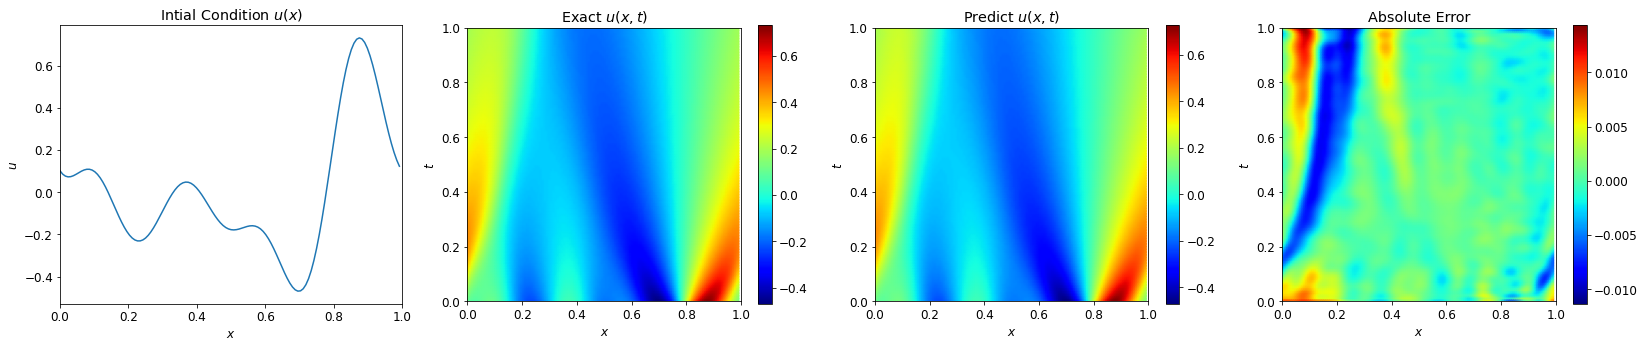

In [6]:
%matplotlib inline
figures_dir = 'Burgers1D/figures/'
os.makedirs(figures_dir, exist_ok=True)
font_size = 12
for key in range(len(preds_y)):
    save_path = os.path.join(figures_dir, f'Burgers1D_{key}')
    plot_predictions(key, test_x, test_y, preds_y, print_index=True, save_path=save_path, font_size=font_size)


# Movies

In [18]:
def generate_movie_1D(key, test_x, test_y, preds_y, plot_title='', movie_dir='', movie_name='movie.gif', frame_basename='movie', frame_ext='jpg', remove_frames=True, font_size=None):
    frame_files = []
    os.makedirs(movie_dir, exist_ok=True)

    if font_size is not None:
        plt.rcParams.update({'font.size': font_size})
    
    pred = preds_y[key]
    true = test_y[key]

    
    a = test_x[key]
    Nt, Nx, _ = a.shape
    u0 = a[0,:,0]
    T = a[:,:,2]
    X = a[:,:,1]
    x = X[0]
    t = T[:,0]

    fig = plt.figure(figsize=(6,5))
    ax = fig.add_subplot(111)
    plt.ion()

    fig.show()
    fig.canvas.draw()
    a = test_x[key]
    Nt, Nx, _ = a.shape
    u0 = a[0,:,0]
    T = a[:,:,2]
    X = a[:,:,1]
    x = X[0]
    ax.plot(x, true[0], 'b-', label='Exact')
    ax.plot(x, pred[0], 'r--', label='PINO Prediction')
    ylim = plt.ylim()
    xlim = [0, 1]
#     plt.xlim(xlim)
#     plt.xlabel(f'$x$')
#     plt.ylabel(f'$u$')
#     plt.title(f'{plot_title} $t={t[0]:.2f}$')
#     plt.legend(loc='lower right')
    plt.tight_layout()
    
    
    
    for i in range(Nt):
        ax.clear()
        ax.plot(x, true[i], 'b-', label='Exact')
        ax.plot(x, pred[i], 'r--', label='PINO Prediction')
        plt.ylim(ylim)
        plt.xlim(xlim)
        plt.xlabel(f'$x$')
        plt.ylabel(f'$u$')
        plt.title(f'{plot_title} $t={t[i]:.2f}$')
        plt.legend(loc='lower right')
        plt.tight_layout()
        fig.canvas.draw()
#         plt.show()
        if movie_dir:
            frame_path = os.path.join(movie_dir,f'{frame_basename}-{i:03}.{frame_ext}')
            frame_files.append(frame_path)
            plt.savefig(frame_path)
    
    if movie_dir:
        movie_path = os.path.join(movie_dir, movie_name)
        with imageio.get_writer(movie_path, mode='I') as writer:
            for frame in frame_files:
                image = imageio.imread(frame)
                writer.append_data(image)
                
    if movie_dir and remove_frames:
        for frame in frame_files:
            try:
                os.remove(frame)
            except:
                pass


## Movie Parameters

In [22]:
data_dir = 'data/Burgers1D'
data_filename = 'data.npz'
data_path = os.path.join(data_dir, data_filename)
test_x, test_y, preds_y = load_data(data_path)
movie_dir = f'Burgers1D/movie/'
os.makedirs(movie_dir, exist_ok=True)



## Movie 1

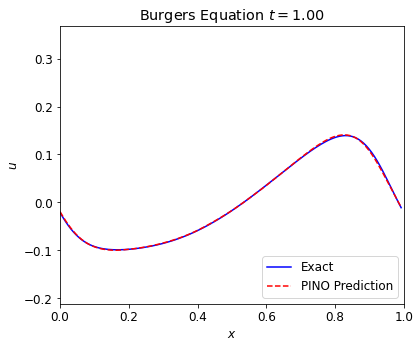

In [23]:
%matplotlib inline
key = 0
movie_name = f'Burgers1D_{key}.gif'
frame_basename = f'Burgers1D_{key}_frame'
frame_ext = 'jpg'
plot_title = "Burgers Equation"
font_size = 12
remove_frames = True

generate_movie_1D(key, test_x, test_y, preds_y, plot_title=plot_title, movie_dir=movie_dir, movie_name=movie_name, frame_basename=frame_basename, frame_ext=frame_ext, remove_frames=remove_frames, font_size=font_size)


## Movie 2

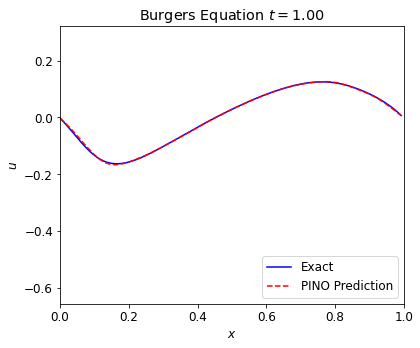

In [24]:
%matplotlib inline
key = 1
movie_name = f'Burgers1D_{key}.gif'
frame_basename = f'Burgers1D_{key}_frame'
frame_ext = 'jpg'
plot_title = "Burgers Equation"
font_size = 12
remove_frames = True

generate_movie_1D(key, test_x, test_y, preds_y, plot_title=plot_title, movie_dir=movie_dir, movie_name=movie_name, frame_basename=frame_basename, frame_ext=frame_ext, remove_frames=remove_frames, font_size=font_size)


## Movie 3

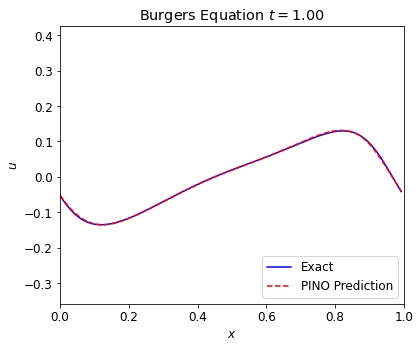

In [25]:
%matplotlib inline
key = 2
movie_name = f'Burgers1D_{key}.gif'
frame_basename = f'Burgers1D_{key}_frame'
frame_ext = 'jpg'
plot_title = "Burgers Equation"
font_size = 12
remove_frames = True

generate_movie_1D(key, test_x, test_y, preds_y, plot_title=plot_title, movie_dir=movie_dir, movie_name=movie_name, frame_basename=frame_basename, frame_ext=frame_ext, remove_frames=remove_frames, font_size=font_size)


<IPython.core.display.Javascript object>


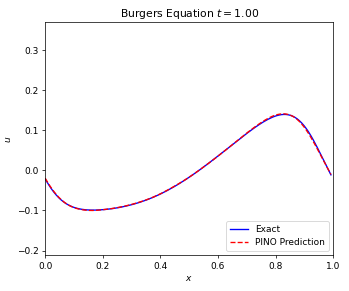

In [59]:
%matplotlib notebook
pred = preds_y[key]
true = test_y[key]
a = test_x[key]
Nt, Nx, _ = a.shape
u0 = a[0,:,0]
T = a[:,:,2]
X = a[:,:,1]
x = X[0]
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()
a = test_x[key]
Nt, Nx, _ = a.shape
u0 = a[0,:,0]
T = a[:,:,2]
X = a[:,:,1]
x = X[0]
ax.plot(x, true[0], 'b-', label='Exact')
ax.plot(x, pred[0], 'r--', label='PINO Prediction')
ylim = plt.ylim()
xlim = [0, 1]
plt.xlim(xlim)
plt.xlabel(f'$x$')
plt.ylabel(f'$u$')
plt.title(f'Burgers Equation $t={t[0]:.2f}$')
plt.legend(loc='lower right')
plt.tight_layout()
for i in range(Nt):
    ax.clear()
    ax.plot(x, true[i], 'b-', label='Exact')
    ax.plot(x, pred[i], 'r--', label='PINO Prediction')
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.xlabel(f'$x$')
    plt.ylabel(f'$u$')
    plt.title(f'Burgers Equation $t={t[i]:.2f}$')
    plt.legend(loc='lower right')
    plt.tight_layout()
    fig.canvas.draw()

In [41]:
key = 0
a = test_x[key]

Nt, Nx, _ = a.shape
u0 = a[0,:,0]
T = a[:,:,2]
X = a[:,:,1]
x = X[0]
t = T[:,0]
t

array([0.        , 0.01      , 0.02      , 0.03      , 0.04      ,
       0.05      , 0.06      , 0.07      , 0.08      , 0.09      ,
       0.1       , 0.11      , 0.12      , 0.13      , 0.14      ,
       0.15000001, 0.16      , 0.17      , 0.18000001, 0.19      ,
       0.2       , 0.20999999, 0.22      , 0.23      , 0.23999999,
       0.25      , 0.25999999, 0.27000001, 0.28      , 0.28999999,
       0.30000001, 0.31      , 0.31999999, 0.33000001, 0.34      ,
       0.34999999, 0.36000001, 0.37      , 0.38      , 0.38999999,
       0.40000001, 0.41      , 0.41999999, 0.43000001, 0.44      ,
       0.44999999, 0.46000001, 0.47      , 0.47999999, 0.49000001,
       0.5       , 0.50999999, 0.51999998, 0.52999997, 0.54000002,
       0.55000001, 0.56      , 0.56999999, 0.57999998, 0.58999997,
       0.60000002, 0.61000001, 0.62      , 0.63      , 0.63999999,
       0.64999998, 0.66000003, 0.67000002, 0.68000001, 0.69      ,
       0.69999999, 0.70999998, 0.72000003, 0.73000002, 0.74000

<IPython.core.display.Javascript object>


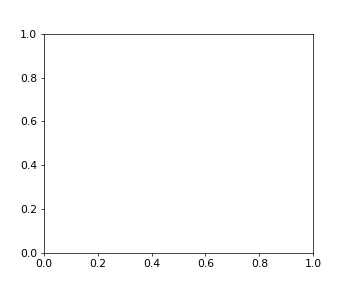

NameError: name 'true' is not defined

In [52]:
%matplotlib notebook
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()
a = test_x[key]
Nt, Nx, _ = a.shape
u0 = a[0,:,0]
T = a[:,:,2]
X = a[:,:,1]
x = X[0]
t = T[:,0]
ax.plot(x, true[0], 'b-', label='Exact')
ax.plot(x, pred[0], 'r--', label='PINO Prediction')
ylim = plt.ylim()
xlim = [0, 1]
plt.tight_layout()



for i in range(Nt):
    ax.clear()
    ax.plot(x, true[i], 'b-', label='Exact')
    ax.plot(x, pred[i], 'r--', label='PINO Prediction')
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.xlabel(f'$x$')
    plt.ylabel(f'$u$')
    plt.title(f'Burgers Equation $t={t[i]:.2f}$')
    plt.legend(loc='lower right')
    plt.tight_layout()
    fig.canvas.draw()
